In [1]:
import xupy as xp
import matplotlib.pyplot as plt
from numpy.ma import masked_array

from ekarus.e2e.utils.image_utils import reshape_on_mask, image_grid

from ekarus.e2e.single_stage_ao_class import SingleStageAO


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
def define_anular_roi(pupil, iwa, owa, oversampling:int):
    mask_shape = max(pupil.shape)
    padded_pupil = xp.pad(1-pupil.copy(), pad_width=int((mask_shape*(oversampling-1)//2)), mode='constant', constant_values=0.0)
    X,Y = image_grid(padded_pupil.shape,recenter=True)
    rho = xp.sqrt(X**2+Y**2)
    where = (rho <= owa*oversampling) * (rho >= iwa*oversampling)
    return where

In [3]:
ssao = SingleStageAO('offaxis_8m')
atmo_phases,res_phases = ssao.load_telemetry_data(data_keys=['mag7_atmo_phases','mag7_residual_phases'])
m2rad = 2*xp.pi/ssao.pyr.lambdaInM
KL, _ = ssao.define_KL_modes(ssao.dm, zern_modes=2)

Initializing devices ...
Modulating 3 [lambda/D] with 20 modulation steps


In [4]:
oversampling = 4
pupil = 1-ssao.cmask

lpff = define_anular_roi(pupil, iwa=0, owa=8, oversampling=oversampling)
hlpff = define_anular_roi(pupil, iwa=0.5, owa=8, oversampling=oversampling)

In [5]:
def there_and_back_again(phase, oversampling, lpff):
    pad_pupil = xp.pad(pupil, pad_width=int((oversampling-1)*max(pupil.shape)/2), mode='constant', constant_values=0.0)
    phase2d = reshape_on_mask(phase, (1-pad_pupil).astype(bool))
    ef = pad_pupil * xp.exp(1j*phase2d*m2rad,dtype=xp.complex64)
    ff = xp.fft.fftshift(xp.fft.fft2(ef))
    filt_ff  = ff * lpff
    pup_ef = xp.fft.ifft2(xp.fft.ifftshift(filt_ff))
    filt_phase = xp.angle(pup_ef)[pad_pupil.astype(bool)]
    return filt_phase/m2rad

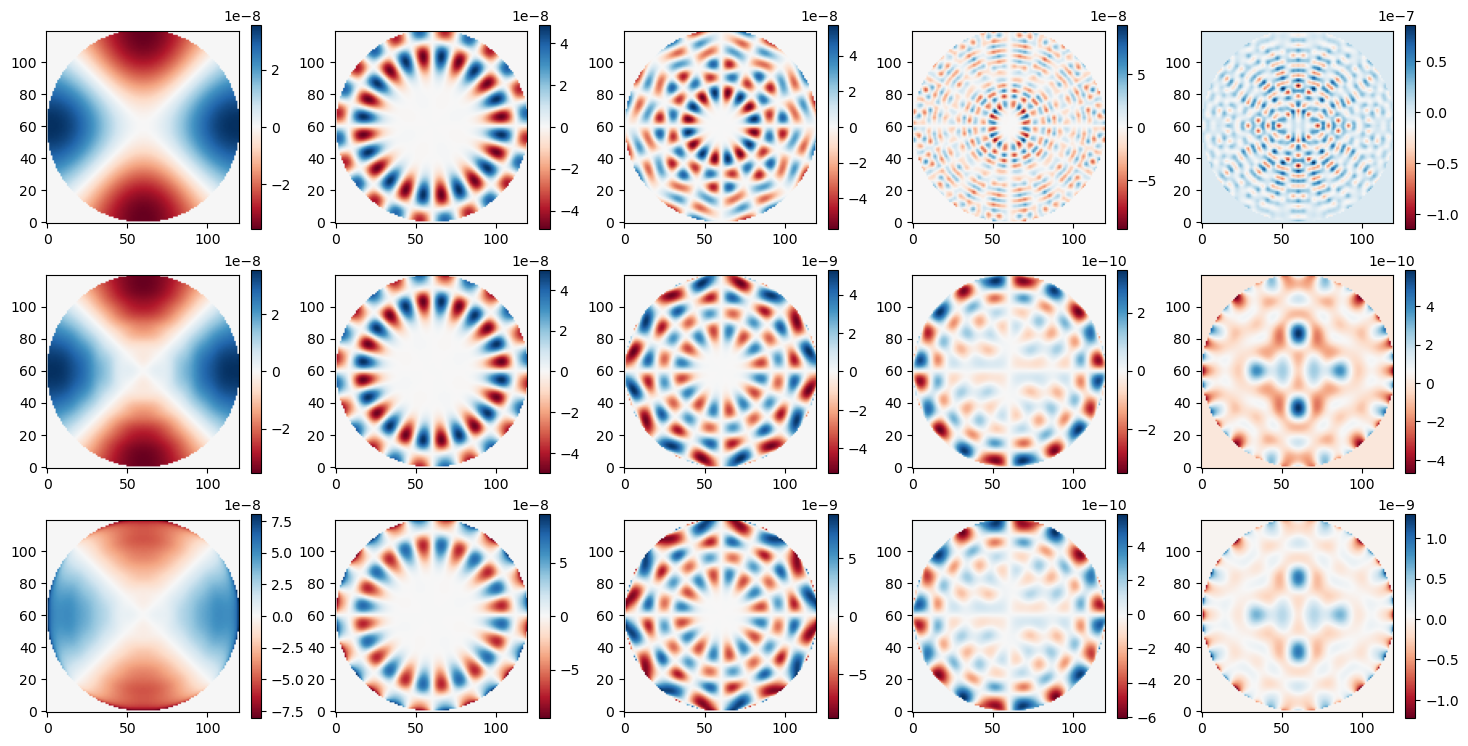

In [6]:
amp = 20e-9

ids = [4,100,200,800,900]

plt.figure(figsize=(18,9))
for j,id in enumerate(ids):
    phase = KL[id,:]*amp
    filt_phase = there_and_back_again(phase, oversampling, lpff)
    afilt_phase = there_and_back_again(phase, oversampling, hlpff)
    plt.subplot(3,len(ids),1+j)
    plt.imshow(xp.asnumpy(reshape_on_mask(phase,(1-pupil).astype(bool))),origin='lower',cmap='RdBu')
    plt.colorbar()
    plt.subplot(3,len(ids),6+j)
    plt.imshow(xp.asnumpy(reshape_on_mask(filt_phase,(1-pupil).astype(bool))),origin='lower',cmap='RdBu')
    plt.colorbar()
    plt.subplot(3,len(ids),11+j)
    plt.imshow(xp.asnumpy(reshape_on_mask(afilt_phase,(1-pupil).astype(bool))),origin='lower',cmap='RdBu')
    plt.colorbar()

In [9]:
filtKL = xp.zeros_like(KL)

for k in range(KL.shape[0]):
    phase = KL[id,:]*amp
    filt_phase = there_and_back_again(phase, oversampling, lpff)
    filtKL[k,:] = filt_phase/xp.std(filt_phase)

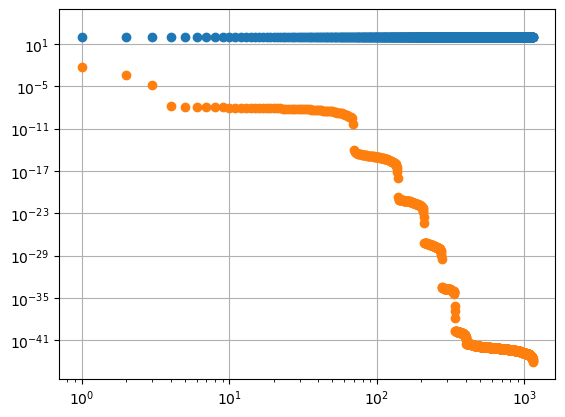

In [10]:
S0 = xp.linalg.svd(KL,compute_uv=False)
U,D,V = xp.linalg.svd(filtKL,full_matrices=False)

plt.figure()
plt.plot(xp.asnumpy(S0),'o')
plt.plot(xp.asnumpy(D),'o')
plt.grid()
plt.xscale('log')
plt.yscale('log')